# Time to get your hands dirty! The irreducible mass of black holes.
For a BH of mass $M$ spin $\chi \in [0,1]$, the irreducible mass is

$$M_{\text{irr}} = M \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$$

For convenience, let us define

$$f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}} = \frac{M_{\text{irr}}}{M}$$

Suppose you have repeated measurements of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that:

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumptions that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

Tasks:
1. Start with a value of $\sigma = 0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu = 1$ in your code and remember that all masses in the problem are measured in units of $\mu$.

2. Plot the resulting pdf of $M_{\text{irr}}$. First try a histogram with one of the rules of thumb we've seen above.

   *Hint:* You don't know the functional form of the pdf of $M_{\text{irr}}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{\text{irr}}$ using a KDE.

4. Compute the KS distance between $M_{\text{irr}}$ and $f$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

5. Compute the KS distance between $M_{\text{irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\text{irr}}$ is distributed like $f$ if $\sigma \ll \mu$ and (ii) $M_{\text{irr}}$ is distributed like $M$ if $\sigma \gg \mu$.

7. [Optional, not examinable] Compute the pdf of $f$ from its mathematical definition (pen and paper!). Verify this result:

    $$\pi(f) = 2 \frac{2f^2 - 1}{\sqrt{1 - f^2}}.$$

8. Compute the pdfs of  $M_{\text{irr}}$ from its mathematical definitions (pen and paper!). Verify this result:

   $$p(M_{\text{irr}}) = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^{1} \exp \left[ -\frac{(M_{\text{irr}}/f - \mu)^2}{2\sigma^2} \right] \frac{2f^2 - 1}{f\sqrt{1 - f^2}} \mathrm{d}f.$$  

The this expression is only semi-analytic; that integral should then be solved numerically.

Hint (for point 8): You want to use this theorem for the product of two random variables.

9. Using the expressions from point 7 and 8, plot those pdfs check that they agree with your KDE reconstructions.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy.integrate import quad

In [ ]:
sigma=0.02
mu=1
N=10000
spin=np.random.uniform(0,1,N) #N values of spin uniformly distributed between 0 and 1
mass=np.random.normal(mu,sigma,N) #N values of mass normally distributed with mu and sigma

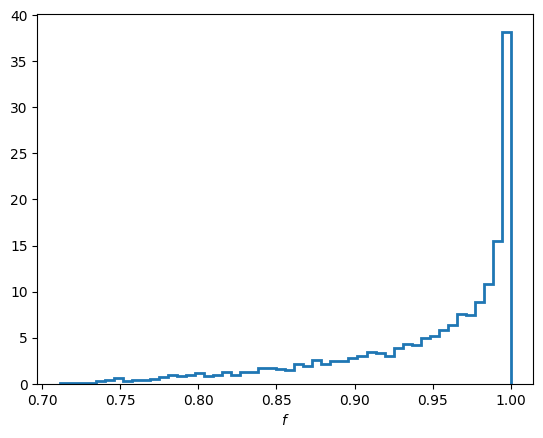

In [ ]:
f=((1+(1-spin**2)**0.5)/2)**0.5 # Compute the quantity f from spin using the given formula
plt.hist(f,density=True,bins=50, histtype='step',lw=2)
plt.xlabel('$f$')
plt.show()


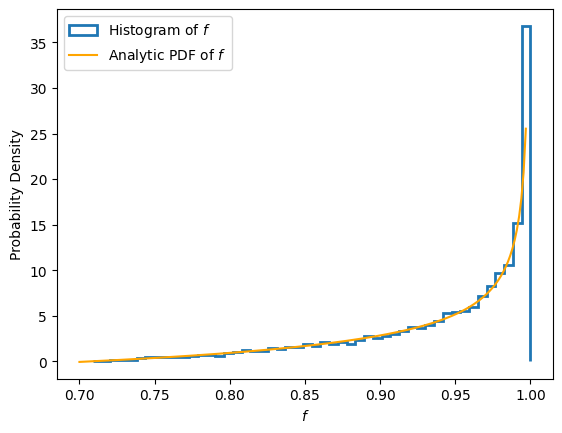

In [32]:
# Definition of the analytic PDF of f over the interval (0, 1)
def pi_f(f):
    return np.where((f > 0) & (f < 1), 2 * (2*f**2 - 1) / np.sqrt(1 - f**2), 0)

f_vals = np.linspace(0.7, 0.997, 200)
pdf_vals = pi_f(f_vals)

plt.hist(f, density=True, bins=50, histtype='step', lw=2, label="Histogram of $f$")
# Plot the analytic PDF
plt.plot(f_vals, pdf_vals, label="Analytic PDF of $f$", color="orange")

plt.xlabel('$f$')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


Text(0.5, 0, '$M$')

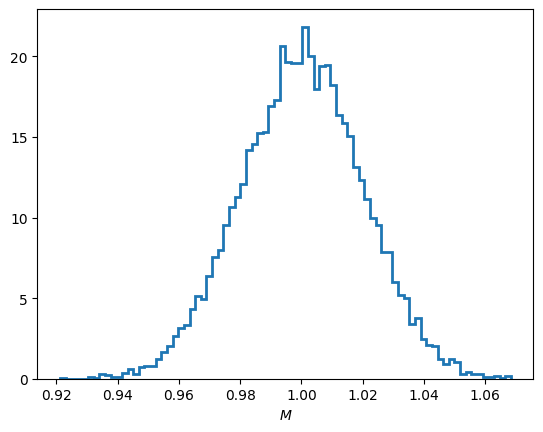

In [ ]:
plt.hist(mass,density=True,histtype='step',bins=80,lw=2) #The mass is gaussian
plt.xlabel('$M$')

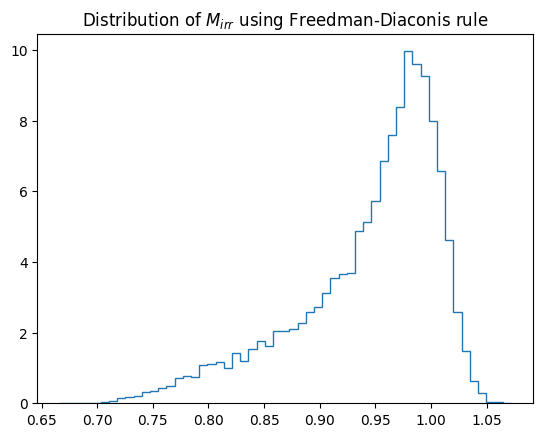

In [ ]:
mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2) # Calculate the irreducible mass using the samples (M_irr) by mass*f(spin) 
_ = fancyhist(mirr, bins="freedman",histtype="step", density=True) # 'bins="freedman"' means the bin width is chosen according to Freedman-Diaconis rule
plt.title("Distribution of $M_{irr}$ using Freedman-Diaconis rule")
plt.show()


KDE representation

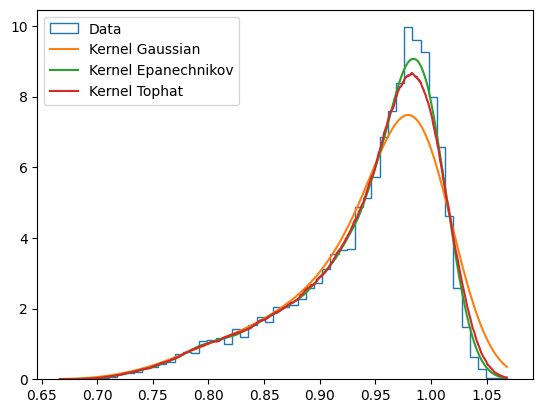

In [7]:
_ = fancyhist(mirr, bins="freedman",histtype="step", density=True, label="Data")
mirr_grid=np.linspace(mirr.min(), mirr.max(),1000)

# Define a function to compute Kernel Density Estimation (KDE)
def kde(data, bandwidth, kernel):
    kde=KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde.fit(data[:, np.newaxis])  # Fit KDE to the data (reshaped to 2D array)
    logpdf=kde.score_samples(mirr_grid[:, np.newaxis]) # Evaluate log-density on mirr_grid points
    return np.exp(logpdf)

# Compute KDE with Gaussian kernel, Epanechnikov kernel and Tophat kernel
pdf1=kde(mirr,bandwidth=0.025,kernel="gaussian")
plt.plot(mirr_grid, pdf1, label="Kernel Gaussian")
pdf2=kde(mirr,bandwidth=0.025,kernel="epanechnikov")
plt.plot(mirr_grid, pdf2, label="Kernel Epanechnikov")
pdf3=kde(mirr,bandwidth=0.025,kernel="tophat") 
plt.plot(mirr_grid, pdf3, label="Kernel Tophat")
plt.legend()
plt.show()



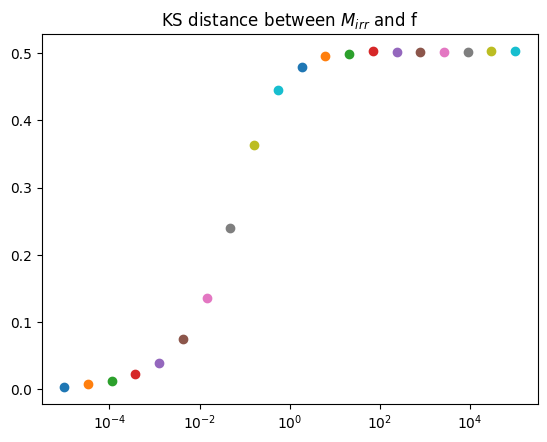

In [ ]:
stat=[]
sigma= np.logspace(-5,5,20) #20 sigma values logarithmically spaced
spin=np.random.uniform(0,1,N)
# Test how the KS distance between M_irr and f changes for different sigma
for i in sigma:
    mass=np.random.normal(mu,i,N)
    mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)
    f=mirr/mass
    # KS test: statistic = maximum distance between the empirical CDFs, p_value=probability of observing such a difference if both samples come from the same distribution
    statistic, p_value =stats.ks_2samp(mirr,f)  
    stat.append(statistic)
    plt.scatter(i,statistic)

plt.semilogx()
plt.title("KS distance between $M_{irr}$ and f ")
plt.show()

    

We can see that for small $\sigma$ the KS distance goes to zero, so $M_{irr}$ is distributed as $f$

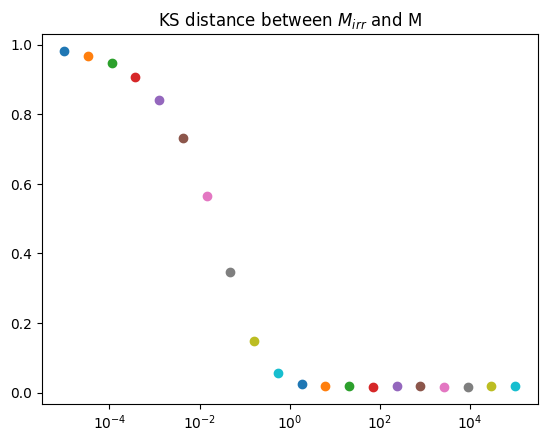

In [10]:
stat=[]
sigma= np.logspace(-5,5,20)
spin=np.random.uniform(0,1,N)
# Test how the KS distance between M_irr and M changes for different sigma
for i in sigma:
    mass=np.random.normal(mu,i,N)
    mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)
    statistic, p_value =stats.ks_2samp(mirr,mass)
    stat.append(statistic)
    plt.scatter(i,statistic)

plt.semilogx()
plt.title("KS distance between $M_{irr}$ and M")
plt.show()

We can see that for large $\sigma$ the KS distance goes to zero, so $M_{irr}$ is distributed as $M$

In [24]:
def integrand(f,mirr,mu,sigma): #integrand 
    esp=-((mirr / f - mu)**2) / (2 * sigma**2) # based on the given formula involving f, mirr, mu, and sigma
    return np.exp(esp) * (2 * f**2 - 1) / (f * np.sqrt(1 - f**2))

def int(mirr,mu,sigma):
    # Compute the integral of 'integrand' over f in [1/sqrt(2), 1]
    integral, error = quad(integrand, 1/np.sqrt(2), 1, args=(mirr, mu, sigma))
    p=np.sqrt(2 / np.pi) / sigma
    return p * integral


In [21]:
sigma=0.02
mu=1
N=10000
spin=np.random.uniform(0,1,N)
mass=np.random.normal(mu,sigma,N)
mirr=mass*np.sqrt((1+np.sqrt(1-spin**2))/2)
f=((1+(1-spin**2)**0.5)/2)**0.5 

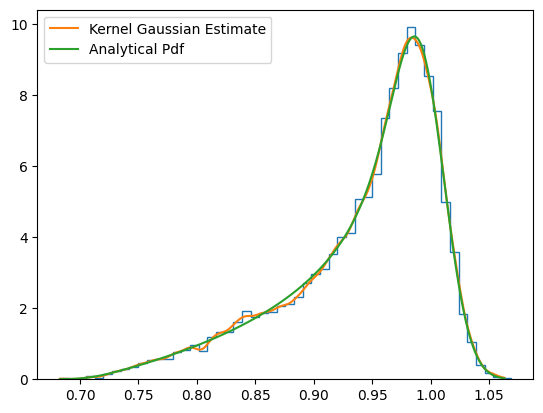

In [22]:
_ = fancyhist(mirr, bins="freedman",histtype="step", density=True)
mirr_grid=np.linspace(mirr.min(), mirr.max(),1000)
# Plot the PDF of M_irr to check that it agree with the KDE reconstructions.
pdf_Mirr=kde(mirr,bandwidth=0.005,kernel="gaussian")  # Kernel density estimate (Gaussian kernel)
plt.plot(mirr_grid, pdf_Mirr, label="Kernel Gaussian Estimate")
pdf=[]
for m in mirr_grid:
    pdf.append(int(m,mu,sigma)) # Compute PDF by numerical integration for each mirr_grid point


plt.plot(mirr_grid, pdf, label="Analytical Pdf")

plt.legend()
plt.show()
